In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy.polynomial import legendre
from astropy.io import fits
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture as ca

In [2]:
def read_data_file(filename):
    data = np.loadtxt(filename, delimiter=',')
    x_in = data[:, 0]
    y_in = data[:, 1]
    x_out = data[:, 2]
    y_out = data[:, 3]
    return x_in, y_in, x_out, y_out

In [3]:
def custom_legendre(x_coeffs, y_coeffs, x, y, order):
    import numpy as np
    from numpy.polynomial import legendre
    x_terms = legendre.legval2d(x, y, x_coeffs)
    y_terms = legendre.legval2d(x, y, y_coeffs)
    return np.array(x_terms), np.array(y_terms)

In [4]:
def residual(coeffs, x_in, y_in, x_out, y_out, order):
    coeffs = coeffs.reshape(2, order, order)

    x_coeffs = coeffs[0, :, :]
    y_coeffs = coeffs[1, :, :]
    fitted_x_terms, fitted_y_terms = custom_legendre(x_coeffs, y_coeffs, x_in, y_in, order)
    residuals = np.concatenate((fitted_x_terms - x_out, fitted_y_terms - y_out))
    return residuals

In [5]:
input_filename = '2023cj.in'
output_filename = '2023cj.out'

# Read input data
x_in, y_in, x_out, y_out = read_data_file(input_filename)

# Parameters
order = 3
max_iters = 10
outlier_threshold = 3.0

for iteration in range(max_iters):
    # Perform outlier rejection using least squares optimization
    initial_coeffs = np.ones(2 * order * order) # Coefficients for both x and y terms
    result = least_squares(residual, initial_coeffs, args=(x_in, y_in, x_out, y_out, order))
    final_coeffs = result.x
    final_coeffs = final_coeffs.reshape(2, order, order)

    final_x_coeffs = final_coeffs[0, :, :]
    final_y_coeffs = final_coeffs[1, :, :]

    
    # Calculate residuals using the final coefficients and fitted values
    fitted_x, fitted_y = custom_legendre(final_x_coeffs, final_y_coeffs, x_in, y_in, order)
    residuals_x = fitted_x - x_out
    residuals_y = fitted_y - y_out

    # Calculate RMS of the transformation
    combined_residuals = np.sqrt(residuals_x**2 + residuals_y**2)
    rms = np.sqrt(np.mean(combined_residuals ** 2))

    # Count and display number of outliers removed
    num_outliers_removed = np.sum(combined_residuals >= outlier_threshold * rms)

    # Print iteration details
    print(f"Iteration {iteration+1}")
    print(f"RMS of the transformation: {rms}")
    print("Number of outliers removed:", num_outliers_removed)
    print("Coefficients:", final_coeffs)

    # Break the loop if no outliers were removed
    if num_outliers_removed == 0:
        break

    # Update the data for the next iteration
    x_in = x_in[combined_residuals < outlier_threshold * rms]
    y_in = y_in[combined_residuals < outlier_threshold * rms]
    x_out = x_out[combined_residuals < outlier_threshold * rms]
    y_out = y_out[combined_residuals < outlier_threshold * rms]

Iteration 1
RMS of the transformation: 2.390815208716261
Number of outliers removed: 2
Coefficients: [[[ 1.70629174e+03 -3.41486219e-01 -1.54711695e-05]
  [-8.80904434e-01 -9.22682365e-05  3.52923605e-08]
  [-1.17626291e-05  3.27223148e-08 -1.25536023e-11]]

 [[ 1.15238232e+03 -9.30788604e-01  8.63054583e-06]
  [ 3.70383996e-01  4.65359588e-05 -2.38298346e-08]
  [ 5.31705771e-06 -1.92177807e-08  9.49009866e-12]]]
Iteration 2
RMS of the transformation: 0.6640118688349077
Number of outliers removed: 5
Coefficients: [[[ 1.72001250e+03 -3.82191153e-01  5.83542551e-07]
  [-9.10890126e-01 -3.10274676e-06 -1.44684916e-10]
  [-1.06118763e-06  1.37193828e-09 -7.72059984e-14]]

 [[ 1.14202750e+03 -9.01714693e-01 -3.95057764e-06]
  [ 3.96688543e-01 -3.07210410e-05  1.04499230e-08]
  [-5.14322274e-06  1.12941060e-08 -3.96988628e-12]]]
Iteration 3
RMS of the transformation: 0.42070336002841796
Number of outliers removed: 7
Coefficients: [[[ 1.72140002e+03 -3.85881369e-01  2.08562261e-06]
  [-9.1541

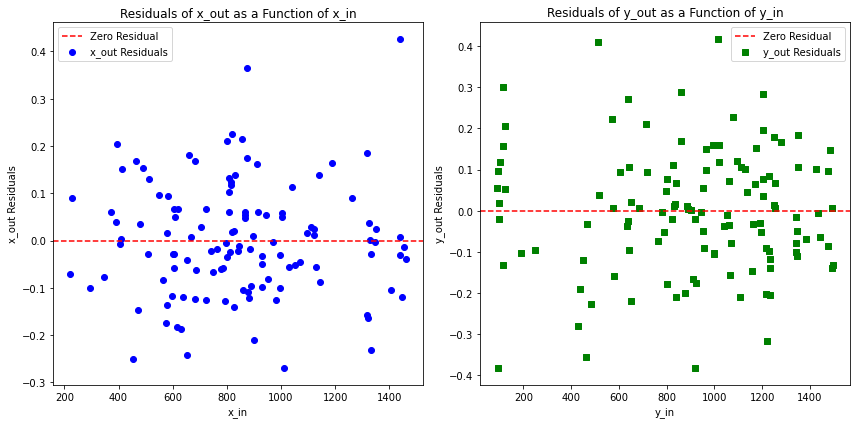

In [9]:
# Plot residuals as functions of x_in and y_in
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x_in, residuals_x, c='b', marker='o', label='x_out Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.xlabel('x_in')
plt.ylabel('x_out Residuals')
plt.title('Residuals of x_out as a Function of x_in')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_in, residuals_y, c='g', marker='s', label='y_out Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.xlabel('y_in')
plt.ylabel('y_out Residuals')
plt.title('Residuals of y_out as a Function of y_in')
plt.legend()
plt.savefig('residuals_x-out_y-out.png', dpi = 500, format = 'png')

plt.tight_layout()
plt.show()

In [ ]:
for i in range(len(x_in)):
    print(x_in[i], y_in[i], residuals_x[i], residuals_y[i])

In [ ]:
print(len(x_in))

In [ ]:
# Write retained points to a file
data = np.column_stack((x_in, y_in, x_out, y_out))  # Stack input and output coordinates
np.savetxt(output_filename, data, delimiter=',', header="x_in,y_in,x_out,y_out", comments='')

In [ ]:
#SN in = 813.68102 789.18635
#SN out = 719.3415020310174 778.6999148972727
sn_pos = [751.134,750.004]
sn_out = custom_legendre(final_x_coeffs, final_y_coeffs, sn_pos[0], sn_pos[1], order)
print(sn_out)

In [ ]:
# SN Pos in ra/dec
# RA: 14:06:32.5593
# Dec: -5:27:06.268

In [ ]:
# Plotting the Position
pre_x, pre_y = 747.69491088, 749.67102569
pre_ex = fits.open('wfc3.f350lp.ref_0001.drz_cropped.fits')
pre_data = pre_ex[0]
img1 = pre_data.data
# zoom = img1[]

pos1 = np.transpose((sn_out))
aps1 = ca(pos1, r = 5.0)

plt.imshow(img1, cmap = 'Greys', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
aps1.plot(color = 'blue', lw = 1.0, alpha = 1.0)
plt.xlim(720,780)
plt.ylim(720,780)
plt.savefig('wfc3.f350lp.ref_0001.drz_cropped_sn_source.png', dpi = 500, format = 'png')